import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import csv
import itertools
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
path = '/Users/fbickfordsmith/Google Drive/Project/attention/'
path_contexts = path+'contexts/simcontexts_wnids.csv'
path_synsets = path+'metadata/synsets.txt'

In [3]:
scatter_styles = {
    'in': dict(label='in context', marker='o', facecolors='none', edgecolors='r'),
    'out': dict(label='out of context', marker='x', facecolors='k')}

In [4]:
# df0: context stats using baseline model
df0 = pd.read_csv(path+'contexts/simcontexts_stats.csv', index_col=0)
df0.head(10)

,wnids,num_examples,num_correct,incontext_acc,outofcontext_acc,incontext_meandistance,incontext_stddistance
0,"['n03743016', 'n01968897', 'n02085936', 'n0379...",2403,1553,0.646275,0.634423,54.411762,17.829769
1,"['n03743016', 'n01855032', 'n03804744', 'n0208...",2410,1600,0.663900,0.633971,70.044609,17.620207
2,"['n03743016', 'n02640242', 'n03476684', 'n0352...",2384,1417,0.594379,0.635737,69.142471,16.232023
3,"['n03743016', 'n02086646', 'n02017213', 'n0422...",2414,1539,0.637531,0.634645,73.596451,17.055941
4,"['n07734744', 'n07860988', 'n02085620', 'n0769...",2317,1560,0.673284,0.633771,50.759323,17.365021
5,"['n07734744', 'n01685808', 'n03447721', 'n1056...",2420,1506,0.622314,0.635036,60.267277,14.426609
6,"['n07734744', 'n03788365', 'n02113023', 'n0439...",2426,1545,0.636851,0.634663,66.545822,15.885822
7,"['n07734744', 'n03089624', 'n02640242', 'n0168...",2391,1515,0.633626,0.634745,73.702171,18.676928
8,"['n01740131', 'n01729322', 'n03594734', 'n0208...",2429,1537,0.632771,0.634768,45.602005,16.410582
9,"['n01740131', 'n01770081', 'n01755581', 'n0279...",2420,1532,0.633058,0.634760,65.880898,15.481185


In [5]:
# df1: context stats using trained models
df1 = pd.read_csv(path+'results/simcontexts_trained_metrics.csv', index_col=0)
df1.head(10)

,incontext_loss,incontext_acc,incontext_top5_acc,outofcontext_loss,outofcontext_acc,outofcontext_top5_acc
0,1.439233,0.659592,0.863920,1.533890,0.635728,0.853085
1,1.211848,0.703734,0.900000,1.542507,0.634013,0.850981
2,1.478048,0.648909,0.868289,1.530375,0.635680,0.853011
3,1.361415,0.651201,0.875311,1.540443,0.634684,0.852647
4,1.343904,0.684506,0.885196,1.537756,0.634387,0.852436
5,1.462090,0.652066,0.866116,1.523472,0.638673,0.854026
6,1.339772,0.664468,0.882110,1.525449,0.636787,0.854053
7,1.478032,0.645337,0.861564,1.531583,0.636160,0.853150
8,1.486829,0.648003,0.867435,1.534418,0.635229,0.853010
9,1.415416,0.664050,0.870661,1.531277,0.637224,0.853422


In [6]:
# df2: points to plot
df2 = pd.DataFrame()
df2['x'] = df0['incontext_meandistance']
df2['y'] = df0['incontext_acc']
df2['z_in'] = df1['incontext_acc'] - df0['incontext_acc']
df2['z_out'] = df1['outofcontext_acc'] - df0['outofcontext_acc']

### Measuring similarity by Euclidean distance

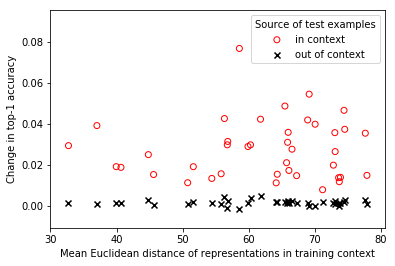

In [7]:
plt.scatter(df2['x'], df2['z_in'], **scatter_styles['in'])
plt.scatter(df2['x'], df2['z_out'], **scatter_styles['out'])
plt.xlabel('Mean Euclidean distance of representations in training context')
plt.ylabel('Change in top-1 accuracy')
plt.legend(title='Source of test examples')
# plt.savefig('simcontexts_acc_change.png', dpi=600)
plt.show()

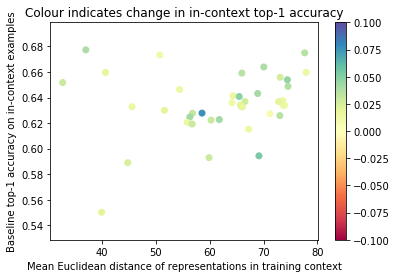

In [8]:
plt.scatter(x=df2['x'], y=df2['y'], c=df2['z_in'], cmap='Spectral', norm=colors.Normalize(vmin=-0.1, vmax=0.1))
plt.colorbar()
plt.xlabel('Mean Euclidean distance of representations in training context')
plt.ylabel('Baseline top-1 accuracy on in-context examples')
plt.title('Colour indicates change in in-context top-1 accuracy')
# plt.savefig('simcontexts_acc_change.png', dpi=600)
plt.show()

### Measuring similarity by cosine distance

In [9]:
wnids = [line.rstrip('\n') for line in open(path_synsets)]
wnid2ind = {wnid:ind for ind, wnid in enumerate(wnids)}
with open(path_contexts) as f:
    contexts = [row for row in csv.reader(f, delimiter=',')]

In [10]:
activations = np.load(path+'activations/activations_mean.npy')
C = 1 - cosine_similarity(activations)
cos_distances = []
for c in contexts:
    inds = [wnid2ind[w] for w in c]
    dists = [C[i, j] for i, j in itertools.product(inds, inds) if i != j]
    cos_distances.append(np.mean(np.array(dists)))

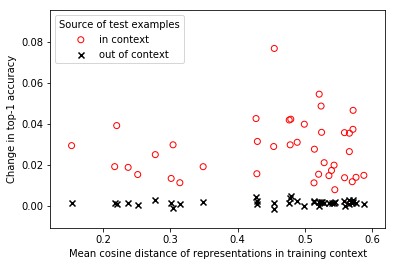

In [11]:
plt.scatter(cos_distances, df2['z_in'], **scatter_styles['in'])
plt.scatter(cos_distances, df2['z_out'], **scatter_styles['out'])
plt.xlabel('Mean cosine distance of representations in training context')
plt.ylabel('Change in top-1 accuracy')
plt.legend(title='Source of test examples')
# plt.savefig('simcontexts_acc_change.png', dpi=600)
plt.show()

### Measuring similarity by Mahalanobis distance

In [13]:
M = np.load(path+'activations/activations_mahalanobis.npy')
mah_distances = []
for c in contexts:
    inds = [wnid2ind[w] for w in c]
    dists = [M[i, j] for i, j in itertools.product(inds, inds) if i != j]
    mah_distances.append(np.mean(np.array(dists)))

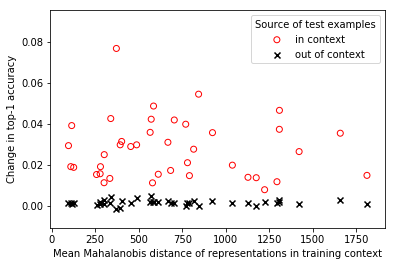

In [14]:
plt.scatter(mah_distances, df2['z_in'], **scatter_styles['in'])
plt.scatter(mah_distances, df2['z_out'], **scatter_styles['out'])
plt.xlabel('Mean Mahalanobis distance of representations in training context')
plt.ylabel('Change in top-1 accuracy')
plt.legend(title='Source of test examples')
plt.show()

### Measuring similarity by Frechet distance

In [15]:
F = np.load(path+'activations/activations_frechet.npy')
fre_distances = []
for c in contexts:
    inds = [wnid2ind[w] for w in c]
    dists = [F[i, j] for i, j in itertools.product(inds, inds) if i != j]
    fre_distances.append(np.mean(np.array(dists)))

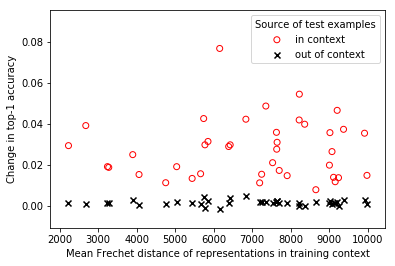

In [16]:
plt.scatter(fre_distances, df2['z_in'], **scatter_styles['in'])
plt.scatter(fre_distances, df2['z_out'], **scatter_styles['out'])
plt.xlabel('Mean Frechet distance of representations in training context')
plt.ylabel('Change in top-1 accuracy')
plt.legend(title='Source of test examples')
plt.show()

### Measuring similarity by KL divergence

In [17]:
KL = np.load(path+'activations/activations_kldivergence.npy')
divergences = []
for c in contexts:
    inds = [wnid2ind[w] for w in c]
    dists = [KL[i, j] for i, j in itertools.product(inds, inds) if i != j]
    divergences.append(np.mean(np.array(dists)))

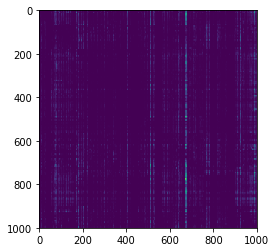

In [52]:
plt.imshow(KL);

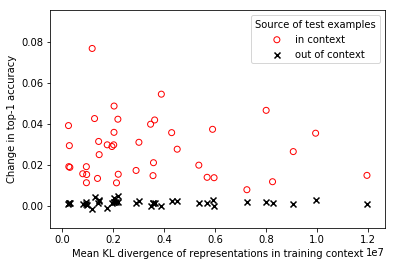

In [18]:
plt.scatter(divergences, df2['z_in'], **scatter_styles['in'])
plt.scatter(divergences, df2['z_out'], **scatter_styles['out'])
plt.xlabel('Mean KL divergence of representations in training context')
plt.ylabel('Change in top-1 accuracy')
plt.legend(title='Source of test examples')
plt.show()

### Measuring similarity by cosine similarity (v2)

In [43]:
S = np.load(path+'activations/activations_dotproduct.npy')
S1 = S.copy()
S1 += np.triu(S1, 1).T
similarities = []
for c in contexts:
    inds = [wnid2ind[w] for w in c]
    sims = [S1[i, j] for i, j in itertools.product(inds, inds) if i != j]
    similarities.append(np.mean(np.array(sims)))

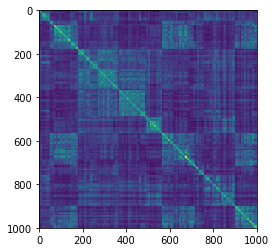

In [44]:
plt.imshow(S1);

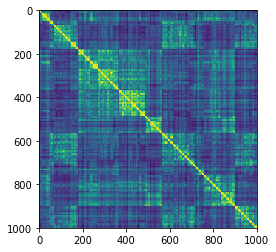

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
A = np.load(path+'activations/activations_mean.npy')
S0 = cosine_similarity(A)
plt.imshow(S0);

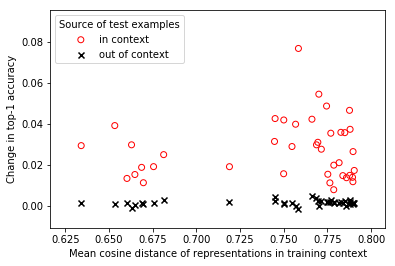

In [50]:
plt.scatter(1-np.array(similarities), df2['z_in'], **scatter_styles['in'])
plt.scatter(1-np.array(similarities), df2['z_out'], **scatter_styles['out'])
plt.xlabel('Mean cosine distance of representations in training context')
plt.ylabel('Change in top-1 accuracy')
plt.legend(title='Source of test examples')
plt.show()